Предстоит построить классификатор текстов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def reading_info():
  train = pd.read_csv('drive/MyDrive/train.csv')
  test = pd.read_csv('drive/MyDrive/test.csv')
  train = train.sample(n = 100000, random_state = 17)
  return train, test


train, test = reading_info()

In [ ]:
train.head()

,title,description,Category_name,Category
56473,Брызговики финские Sukkela на любую машину,Отличные новые брызговики из Финляндии. /\n/\n...,Запчасти и аксессуары,10
2972515,Б у кпп механика DLP DNZ DRZ CZB DUS DUU DUV 02K,Контрактная механическая коробка передач б у К...,Запчасти и аксессуары,10
2039205,Много сумок,"1 фото:/\nСумка вместительная Luis Vuitton, ma...","Одежда, обувь, аксессуары",27
3739784,Зимний комбинезон,"Зимний комбинезон,без дырочек и затертостей,по...",Детская одежда и обувь,29
1941972,Картофель,"Продаю картофель местный, ведро - 200 руб.",Продукты питания,82


In [ ]:
test['description'].head()

0    Мастерка фирмы форвард. Белого цвета. В идеаль...
1    Продаю зимние сапоги, в хорошем состоянии, все...
2    В комплект Atis AMD-2MIR-8kit входит: /\n1. Ку...
3                                         Запчасти GLE
4    Состояние 5+/\nПродаю потому что не нужен/\n18...
Name: description, dtype: object

In [ ]:
train.isna().sum()

title            0
description      0
Category_name    0
Category         0
dtype: int64

In [ ]:
test.isna().sum()

title          0
description    1
itemid         0
dtype: int64

In [ ]:
train = train.fillna("")
test = test.fillna("")

In [ ]:
train['text_info']=train['title']+' '+train['description']

In [ ]:
test['text_info'] = test['title']+' '+test['description']

In [ ]:
len(train.groupby('Category')['title'].count())

50

1. итого 50 уникальных классов

In [ ]:
cat_bar = train.groupby(['Category'], as_index=False)['title'].size()
overall = cat_bar['size'].sum()
cat_bar['frequency'] = cat_bar['size'] / overall

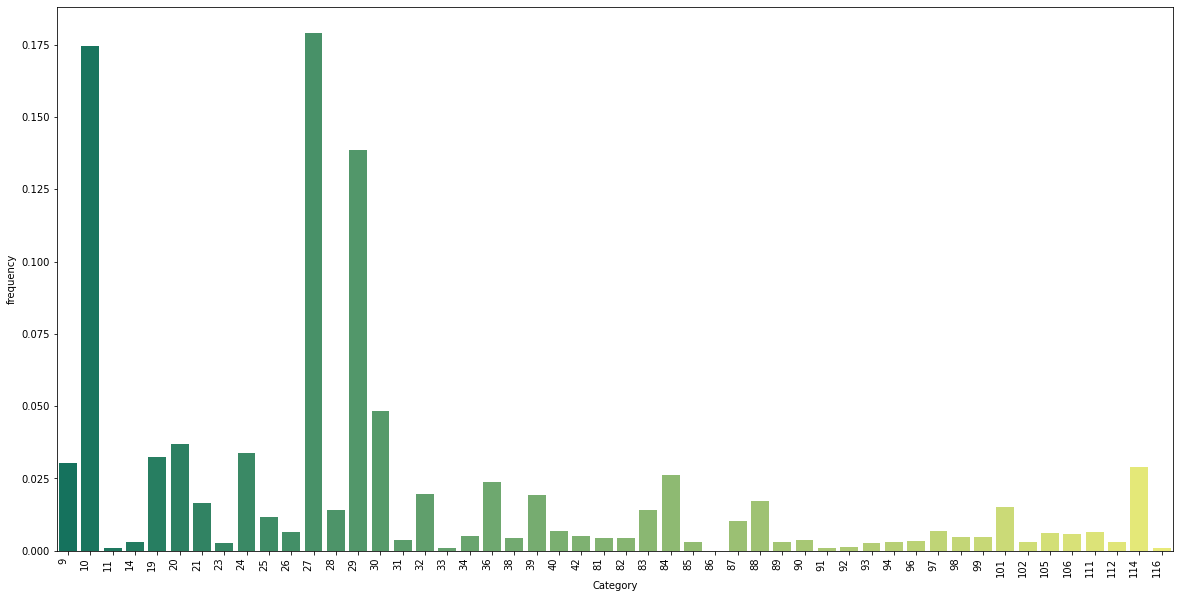

In [ ]:
fig = plt.figure(figsize=(20, 10))
sbarplot = sns.barplot(x='Category', y='frequency', data=cat_bar, palette='summer')
_ = sbarplot.set_xticklabels(sbarplot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

Дисбаланс классов между самым часто встречающимся классом и самым редким, видно,  достаточно большой. Но в целом стандартное отклонение не очень большое - 4%, так как есть довльно большое число классов примерно с одинаковой частотой.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
train = train[['text_info', 'Category']]
train

,text_info,Category
56473,Брызговики финские Sukkela на любую машину Отл...,10
2972515,Б у кпп механика DLP DNZ DRZ CZB DUS DUU DUV 0...,10
2039205,Много сумок 1 фото:/\nСумка вместительная Luis...,27
3739784,"Зимний комбинезон Зимний комбинезон,без дыроче...",29
1941972,"Картофель Продаю картофель местный, ведро - 20...",82
...,...,...
4136736,Пакетом женские вещи р.44-46 Большой пакет хор...,27
2076437,"3-к квартира, 61 м², 1/2 эт. Срочно продаю 3х ...",24
1541098,Бамперы газ-21 Передний и задний бамперы ГАЗ-2...,10
1271554,Плата видео захвата A101602-A5 В отличном сост...,101


In [ ]:
texts = train['text_info'].values

In [ ]:
vec = CountVectorizer(token_pattern='\S+')
bow = vec.fit_transform(texts)

матрица получилась размера 100000x524841 

In [ ]:
import re

In [ ]:
keys = ' '.join(vec.vocabulary_.keys())
prog= re.compile('[ ]+[0-9]+[А-Яа-яёa-zA-Z\-]*')
num_words = prog.findall(keys)

In [ ]:
prog2 = re.compile('[ ]+[\!\"\#\$\%\&\;\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\\\]\^\_\`\{\|\}\~]+[0-9А-Яа-яёa-zA-Z\-]*')
punct_words = prog2.findall(keys)
punct_words[350:360]

[' (центр',
 ' (очень',
 ' (спина',
 ' ,на',
 ' ,шикарные',
 ' ).',
 ' (12-18мес',
 ' (пугачева',
 ' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~/',
 ' ,ребёнок']

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download("stopwords")
russian_stopwords = stopwords.words('russian')
stemmer = SnowballStemmer('russian')


def tokenizer(x):
  tokens = word_tokenize(x.lower())
  tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords\
              and token != " "\
              and token.isalpha()]
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vec_CV = CountVectorizer(tokenizer=tokenizer)
bow = vec_CV.fit_transform(texts)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(bow, train['Category'], random_state=17, train_size=0.8 )

In [ ]:
from sklearn.linear_model import SGDClassifier
clf0 = SGDClassifier()
clf0.fit(x_train, y_train)
pred = clf0.predict(x_test)

In [ ]:
print(f'accuracy_score: {accuracy_score(y_test, pred)}')

accuracy_score: 0.82615


теперь сделаем предсказания по всей тестовой выборке

In [ ]:
text = test['text_info'].values

In [ ]:
bow = vec_CV.transform(text)
pred = clf0.predict(bow)

In [ ]:
result = pd.DataFrame()
result['Category'] = pred

In [ ]:
result['Id'] = test['itemid'].values

In [ ]:
result.to_csv('dz6.csv', index=False, columns=['Id', 'Category'])

In [ ]:
#отправил решение на kaggle по авито